In [7]:
import numpy  as np 
import pandas as pd
from   glob   import glob
import itertools
import importlib
import time
import os
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
np.set_printoptions(edgeitems=30, linewidth=1000, formatter=dict(float=lambda x: "%.3g" % x))
np.set_printoptions(precision=8)

from tp_config import *
from tp_utils.data_provider import  read_prices, read_data

%matplotlib inline


In [7]:
def read_data_shares(asset):
    df = pd.read_csv(os.path.join(DATA_PATH_SHARES, asset +'.csv'))
    df.columns = ['T','O', 'H', 'L', 'Close', 'C', 'V']
    return df

In [14]:
#Торговля одним контрактом
def simulation_01(df_signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission'] / 100
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
    contract        = init_data['contract']
     
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0    
    market_position = 0
    
    ticks = df_signals['close'].values
    signals = df_signals['signals'].values
    trade_statistics = []
    trades = 0

    for i in range(len(signals)) :
        trade_profit = 0
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares    = num_shares + contract
            open_position = num_shares * price*(1+commission)
            market_position = 1
            
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            close_position = num_shares * price * (1-commission)
            trade_profit = close_position - open_position
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
            trades = trades + 1
        else:
            signals[i] = 0
        
        if signals[i] !=0:
            trade_statistics.append([ticks[i], signals[i], market_position, num_shares, trade_profit, cum_profit, trades])            
        

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'num_shares', 'profit', 'cum_profit', 'trades']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    df['high_val'] = df['cum_profit'].cummax()
    df['drawdown'] = df['cum_profit'] - df['high_val']

    return df
    #return 0

In [77]:

init_data = {'exchange_commission': 0., #percent
             'start_capital'     : 1,
             'buy_correction'    : 1,
             'sell_correction'   : 1,
             'contract'          : 0.1,  
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

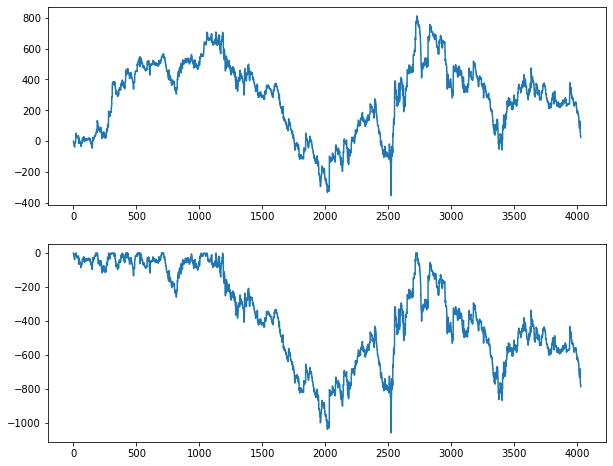

In [90]:
from pylab import plt
df_signals = pd.read_csv('r_macd.csv')


res = simulation_01(df_signals, init_data)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10,8))

res['cum_profit'].plot(ax=axes[0])
res['drawdown'].plot(ax=axes[1])
plt.show()

In [72]:
xx = res[res.signal == -1]
xx[xx.profit>0]

,price,signal,MP,num_shares,profit,cum_profit,trades,high_val,drawdown
1,48636.36,-1,0,0.0,10.340,10.340,1,10.340,0.000
3,48693.70,-1,0,0.0,1.490,11.830,2,11.830,0.000
5,48700.00,-1,0,0.0,6.453,18.283,3,18.283,0.000
7,48731.26,-1,0,0.0,10.097,28.380,4,28.380,0.000
11,49200.00,-1,0,0.0,36.711,49.129,6,49.129,0.000
...,...,...,...,...,...,...,...,...,...
2885,36457.48,-1,0,0.0,8.123,821.937,1443,894.058,-72.121
2893,35971.65,-1,0,0.0,1.483,813.891,1447,894.058,-80.167
2895,35857.00,-1,0,0.0,24.698,838.589,1448,894.058,-55.469
2897,36159.73,-1,0,0.0,11.137,849.726,1449,894.058,-44.332


In [8]:

def ts_to_datetime(ts):
#datetime.utcfromtimestamp(ts)
    return datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

#Торговля одним контрактом
def simulation_00(prices, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission'] / 100
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
    contract        = init_data['contract']
     
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0    
    market_position = 0
    
    ticks = prices['C'].values
    times = prices['T'].values
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    times = times[start:]
    trade_statistics = []
    trades = 0

    for i in range(len(signals)) :
        ts = ts_to_datetime(times[i]/1000)
        trade_profit = 0
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares    = num_shares + contract
            open_position = num_shares * price*(1+commission)
            market_position = 1
            
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            close_position = num_shares * price * (1-commission)
            trade_profit = close_position - open_position
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
            trades = trades + 1
        else:
            signals[i] = 0
        
        if signals[i] !=0:
            trade_statistics.append([ts, ticks[i], signals[i], market_position, num_shares, trade_profit, cum_profit, trades])            
        

    df = pd.DataFrame(trade_statistics)
    df.columns = ['time', 'price', 'signal', 'MP', 'num_shares', 'profit', 'cum_profit', 'trades']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    df['high_val'] = df['cum_profit'].cummax()
    df['drawdown'] = df['cum_profit'] - df['high_val']

    return df
    #return 0

In [10]:
#vectorized simulation
from TA_robots import ma_2_crossover
robot = ma_2_crossover()
#robot = rsi()
params = robot.ps_ranges

ticket = 'BTC-USDT'
tf = '1h'
#tf = '5m'
from_date = '2020-01-01'

prices = read_data(ticket, tf, from_date)
signals = robot.signals(prices, 12 , 25, 1)


init_data = {'exchange_commission': 0.075, #percent
             'start_capital'     : 1,
             'buy_correction'    : 1.0001,
             'sell_correction'   : 0.9999,
             'contract'          : 0.1,  
             'robot_name'        : '',
             'market'            : '',
             'kline'             : ''  
            }

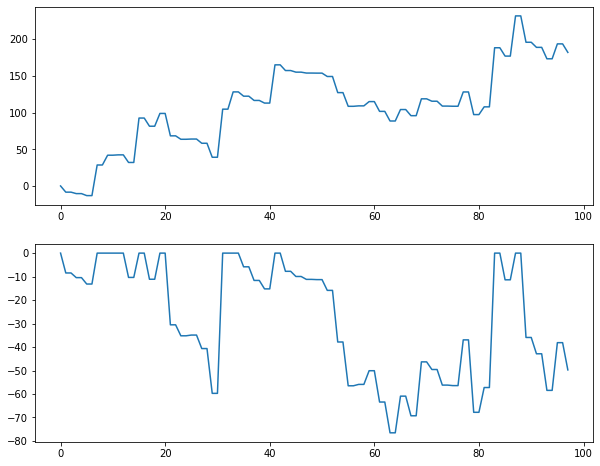

In [12]:
from pylab import plt

res = simulation_00(prices, signals, init_data)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (10,8))

res['cum_profit'].plot(ax=axes[0])
res['drawdown'].plot(ax=axes[1])
plt.show()

In [61]:
res

,time,price,signal,MP,num_shares,profit,cum_profit,trades
0,2020-01-01 16:00:00,7225.59,1,1,1,0.000000000,0.000000000,0
1,2020-01-02 08:00:00,7142.21,-1,0,0,-112.002192309,-112.002192309,1
2,2020-01-03 14:00:00,7312.25,1,1,1,0.000000000,-112.002192309,1
3,2020-01-04 13:00:00,7363.88,-1,0,0,22.119471816,-89.882720492,2
4,2020-01-04 15:00:00,7336.45,1,1,1,0.000000000,-89.882720492,2
...,...,...,...,...,...,...,...,...
78,2020-03-17 04:00:00,5070.72,1,1,1,0.000000000,549.585796107,39
79,2020-03-18 14:00:00,5082.40,-1,0,0,-8.687565528,540.898230579,40
80,2020-03-19 04:00:00,5347.31,1,1,1,0.000000000,540.898230579,40
81,2020-03-21 05:00:00,6285.00,-1,0,0,912.503051050,1453.401281629,41


In [3]:
#Торговля на всю котлету
def simulation(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
            
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0

In [4]:
def simulation_short(ticks, signals, init_data):
    market          = init_data['market']
    commission      = init_data['exchange_commission']
    start_capital   = init_data['start_capital']
    buy_correction  = init_data['buy_correction']
    sell_correction = init_data['sell_correction']
     
    cur_capital  = start_capital 
    num_shares   = 0
    trade_profit = 0
    cum_profit   = 0
    
    market_position = 0
    start = len(ticks) - len(signals) 
    ticks = ticks[start:]
    trade_statistics = []
    #trade_statistics = np.zeros((len(signals),7))
    for i in range(len(signals)) :
        
        #long entry
        if market_position == 0 and signals[i] == 1:
            price = ticks[i] * buy_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = -cur_capital
            cur_capital  = 0
            market_position = 1
        #long exit
        elif market_position == 1 and signals[i] == -1:
            price = ticks[i] * sell_correction
            cur_capital  = (num_shares * price)*(1-commission)
            trade_profit = trade_profit + cur_capital
            cum_profit  += trade_profit
            num_shares   = 0
            market_position = 0
        #short entry
        elif market_position == 0 and signals[i] == -1:
            price = ticks[i] * sell_correction
            num_shares   = cur_capital * (1-commission)/price
            trade_profit = num_shares * price
            market_position = 2
        #short exit
        elif market_position == 2 and signals[i] == 1:    
            price = ticks[i] * buy_correction
            cur_capital  = (num_shares * price)*(1-commission)
            num_shares = 0
            trade_profit = trade_profit - cur_capital
            market_position = 0
        else:
            signals[i] = 0
            
        trade_statistics.append([ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit])            
        #trade_statistics[i] = [ticks[i], signals[i], market_position, cur_capital, num_shares, trade_profit, cum_profit]

    df = pd.DataFrame(trade_statistics)
    df.columns = ['price', 'signal', 'MP', 'capital', 'num_shares', 'profit', 'cum_profit']
    df = df.astype({'signal':np.int32, 'MP':np.int32})
    return df
    #return 0

In [ ]:
df[df['MP'] != df['']]

In [24]:
df[df['signal'] != 0]

,price,signal,MP,capital,num_shares,profit,cum_profit
134,4158.56,1,1,0.000000000,0.024046785,-100.000000000,0.000000000
1175,4580.00,-1,0,110.134277250,0.000000000,10.134277250,10.134277250
1526,4541.11,1,1,0.000000000,0.024252722,-110.134277250,10.134277250
3743,3937.75,-1,0,95.501155057,0.000000000,-14.633122193,-4.498844943
4475,4280.00,1,1,0.000000000,0.022313354,-95.501155057,-4.498844943
5103,4780.00,-1,0,106.657832050,0.000000000,11.156676993,6.657832050
5217,4740.00,1,1,0.000000000,0.022501652,-106.657832050,6.657832050
5348,5097.00,-1,0,114.690921932,0.000000000,8.033089882,14.690921932
5636,5570.01,1,1,0.000000000,0.020590793,-114.690921932,14.690921932
6144,5984.70,-1,0,123.229717807,0.000000000,8.538795876,23.229717807


In [14]:
import datetime as dt
from datetime import datetime 
import backtrader as bt
import pandas_datareader as web

In [10]:
# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

In [16]:
from datetime import datetime
import backtrader as bt

# Create a subclass of Strategy to define the indicators and logic

class SmaCross(bt.Strategy):
    # list of parameters which are configurable for the strategy
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position


cerebro = bt.Cerebro()  # create a "Cerebro" engine instance

# Create a data feed
data = bt.feeds.YahooFinanceData(dataname='MSFT',
                                 fromdate=datetime(2011, 1, 1),
                                 todate=datetime(2012, 12, 31))

cerebro.adddata(data)  # Add the data feed

cerebro.addstrategy(SmaCross)  # Add the trading strategy
cerebro.run()  # run it all
cerebro.plot()  # and plot it with a single command

FileNotFoundError: [Errno 2] No such file or directory: 'MSFT'